<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/bi-2021/blob/main/materialy-wyklady/bi_2021_04_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowanie danych i pakietów

Pobieramy dane z github wykorzystując funkcję `download.file`

In [3]:
download.file("https://raw.githubusercontent.com/DepartmentOfStatisticsPUE/bi-2021/main/data/popyt-zajecia-dane.csv",
              "popyt-dane.csv")

Dziś na zajęciach skorzystamy z pakietu `tidyverse`, `vcd` (korelacje dla cech jakościowych) oraz wbudowanych w R funkcji (`glm`, `optim`).

In [1]:
install.packages("vcd")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘lmtest’




Ładujemy potrzebne pakiety

In [ ]:
library(tidyverse)
library(vcd)

Wczytujemy dane

In [5]:
dane <- read.csv("popyt-dane.csv", stringsAsFactors = FALSE)
head(dane)

,id_popyt,id_jednostki,waga,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca,id_cbop,jedna_zmiana,wymiar_40,wolne_miejsca_cbop,wolne_miejsca_niepeln_cbop
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<int>,<int>
1,1,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,1,2,NA,NA,NA,NA,NA
2,2,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,2,7,NA,NA,NA,NA,NA
3,3,c9dbaf50890165ebe810aa770de0e9df903dc35b,6,1,D,O,24,2,6,NA,NA,NA,NA,NA
4,4,718e0bba42bcec6ed98f9690db6d26cb7b93c880,1,1,D,R.S,14,2,7,NA,NA,NA,NA,NA
5,5,532a1879a692b9d7bbb7282ba757d028156ef341,1,1,D,R.S,14,2,6,NA,NA,NA,NA,NA
6,6,0b6b623fa45e257284a3049d097af322841337e3,1,1,D,R.S,22,2,1,NA,NA,NA,NA,NA


# Przygotowujemy dane do estymacji 

Na zajęciach wykorzystamy podejście opisane w pracy:

+ Kim, J. K., \& Wang, Z. (2019). **Sampling techniques for big data analysis**. *International Statistical Review*, 87, S177-S191

Uwaga, w próbie mamy dwie populacje: 

+ **podmioty gospodarcze**, które opisują zmienne: `sek`, `klasa_pr`, `sekc_pkd`, `woj`
+ **wolne miejsca pracy**, które opisuje zmienna: `zawod_kod2`

Naszym celem jest estymacja odsetka wolnych miejsc pracy, w których pracodawcy poszukują osób na jedną zmianę (`jedna_zmiana`) 


Aby tego dokonać podejmujemy następujące kroki:


1. wydzielimy próbę losową,
2. zidentyfikujemy, te jednostki i oferty, które znajdowały się w zbiorze CBOP,
3. sprawdzimy korelacje dla zmiennych jakościowych (`V Cramera)`,
4. obliczamy propensity score ($\rho_i$),
5. wydzielamy próbę nielosową i przypisujemy $\hat{\rho}_i$ z modelu z punktu 4,
6. estymujemy intersującą nas charakterystykę (odsetek ofert na jedną zmianę).




## Krok 1 i 2 -- wydzielamy próbę losową i identyfikujemy jednostki

Próba losowa

In [60]:
proba_los <- dane %>% 
  filter(!is.na(id_popyt)) %>%
  select(id_popyt, id_cbop, id_jednostki, waga:wolne_miejsca) %>%
  mutate(R = !is.na(id_cbop),
         waga_miejsca = waga*wolne_miejsca,
         waga_miejsca_scaled = waga_miejsca/mean(waga_miejsca)) %>%
  mutate_at(vars(sek, woj, zawod_kod2), as.factor)

head(proba_los)

,id_popyt,id_cbop,id_jednostki,waga,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca,R,waga_miejsca,waga_miejsca_scaled
,<int>,<int>,<chr>,<int>,<fct>,<chr>,<chr>,<fct>,<fct>,<int>,<lgl>,<int>,<dbl>
1,1,NA,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,1,2,FALSE,2,0.06778256
2,2,NA,a9cc990df6a99ab215a1bc13f51d4825c7d52d18,1,1,D,O,14,2,7,FALSE,7,0.23723895
3,3,NA,c9dbaf50890165ebe810aa770de0e9df903dc35b,6,1,D,O,24,2,6,FALSE,36,1.22008604
4,4,NA,718e0bba42bcec6ed98f9690db6d26cb7b93c880,1,1,D,R.S,14,2,7,FALSE,7,0.23723895
5,5,NA,532a1879a692b9d7bbb7282ba757d028156ef341,1,1,D,R.S,14,2,6,FALSE,6,0.20334767
6,6,NA,0b6b623fa45e257284a3049d097af322841337e3,1,1,D,R.S,22,2,1,FALSE,1,0.03389128


Ile podmiotów z próby popytu było w CBOP? (bez przeważania)

In [22]:
proba_los %>% distinct(R, id_jednostki) %>% count(R)

R,n
<lgl>,<int>
FALSE,6290
TRUE,430


A ile wolnych miejsc pracy? Uwzględniamy wagę

In [62]:
proba_los %>% count(R, wt = waga_miejsca)

R,n
<lgl>,<int>
FALSE,283219
TRUE,11075


## Krok 3 -- korelacje

Jakie zmienne są skorelowane z obserwacją w zbiorze CBOP? Kolejne kody sprawdzają: sektor, kod zawodu, kasę wielkosci czy województwo.

In [41]:
tab_sek <- xtabs(waga_miejsca ~ R + sek, data = proba_los)
tab_sek_res <- assocstats(tab_sek)
tab_sek_res

                    X^2 df   P(> X^2)
Likelihood Ratio 25.387  1 4.6897e-07
Pearson          26.352  1 2.8457e-07

Phi-Coefficient   : 0.009 
Contingency Coeff.: 0.009 
Cramer's V        : 0.009 

In [42]:
tab_zawod <- xtabs(waga_miejsca ~ R + zawod_kod2, data = proba_los)
tab_zawod_res <- assocstats(tab_zawod)
tab_zawod_res

                    X^2 df P(> X^2)
Likelihood Ratio 2064.8  7        0
Pearson          2012.0  7        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.082 
Cramer's V        : 0.083 

In [43]:
tab_wielk <- xtabs(waga_miejsca ~ R + klasa_pr, data = proba_los)
tab_wielk_res <- assocstats(tab_wielk)
tab_wielk_res

                    X^2 df P(> X^2)
Likelihood Ratio 3361.2  2        0
Pearson          3540.8  2        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.109 
Cramer's V        : 0.11 

In [44]:
tab_woj <- xtabs(waga_miejsca ~ R + woj, data = proba_los)
tab_woj_res <- assocstats(tab_woj)
tab_woj_res

                     X^2 df P(> X^2)
Likelihood Ratio  5885.6 15        0
Pearson          10544.4 15        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.186 
Cramer's V        : 0.189 

In [45]:
tab_pkd <- xtabs(waga_miejsca ~ R + sekc_pkd, data = proba_los)
tab_pkd_res <- assocstats(tab_pkd)
tab_pkd_res

                    X^2 df P(> X^2)
Likelihood Ratio 3213.2 13        0
Pearson          2953.7 13        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.1 
Cramer's V        : 0.1 

Podsumowanie obliczeń. Jaki wniosek?

In [46]:
print(
  round(c("sek" = tab_sek_res$cramer,  "zawod" = tab_zawod_res$cramer, "wielk" = tab_wielk_res$cramer,
          "woj" = tab_woj_res$cramer, "pkd" = tab_pkd_res$cramer),4)
)

   sek  zawod  wielk    woj    pkd 
0.0095 0.0827 0.1097 0.1893 0.1002 


## Krok 4 -- model

Estymujemy $\rho$ stosując funkcję logistyczną (logit i probit) wykorzystując funkcję `glm` oraz 4 zmienne: województwo (`woj`), wielkość (`klasa_pr`), zawód (`zawod_kod2`) oraz sekcję PKD (`sekc_pkd`).

In [95]:
model1 <- glm(formula = R ~ woj + klasa_pr + zawod_kod2 + sekc_pkd, 
              data = proba_los,
              family = binomial(link = "logit"),
              weights = waga_miejsca_scaled)

model2 <- glm(formula = R ~ woj + klasa_pr + zawod_kod2 + sekc_pkd, 
              data = proba_los,
              family = binomial(link = "probit"),
              weights = waga_miejsca_scaled)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


Przyjrzyjmy się modelowi 1 

In [96]:
summary(model1)


Call:
glm(formula = R ~ woj + klasa_pr + zawod_kod2 + sekc_pkd, family = binomial(link = "logit"), 
    data = proba_los, weights = waga_miejsca_scaled)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3942  -0.2124  -0.1251  -0.0679  10.6730  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.72374    0.73791  -6.402 1.54e-10 ***
woj4         0.35943    0.35741   1.006 0.314577    
woj6        -0.53974    0.37066  -1.456 0.145349    
woj8        -0.37752    0.54601  -0.691 0.489296    
woj10       -0.69099    0.38266  -1.806 0.070952 .  
woj12       -0.33871    0.30792  -1.100 0.271331    
woj14        0.16821    0.23840   0.706 0.480448    
woj16        0.48120    0.44615   1.079 0.280781    
woj18        2.57420    0.26568   9.689  < 2e-16 ***
woj20        0.62053    0.43664   1.421 0.155276    
woj22       -0.11870    0.31258  -0.380 0.704121    
woj24        0.32566    0.25610   1.272 0.203520    
woj26       -0.22511    0.52

Zobaczymy teraz rozkład $\rho_1$

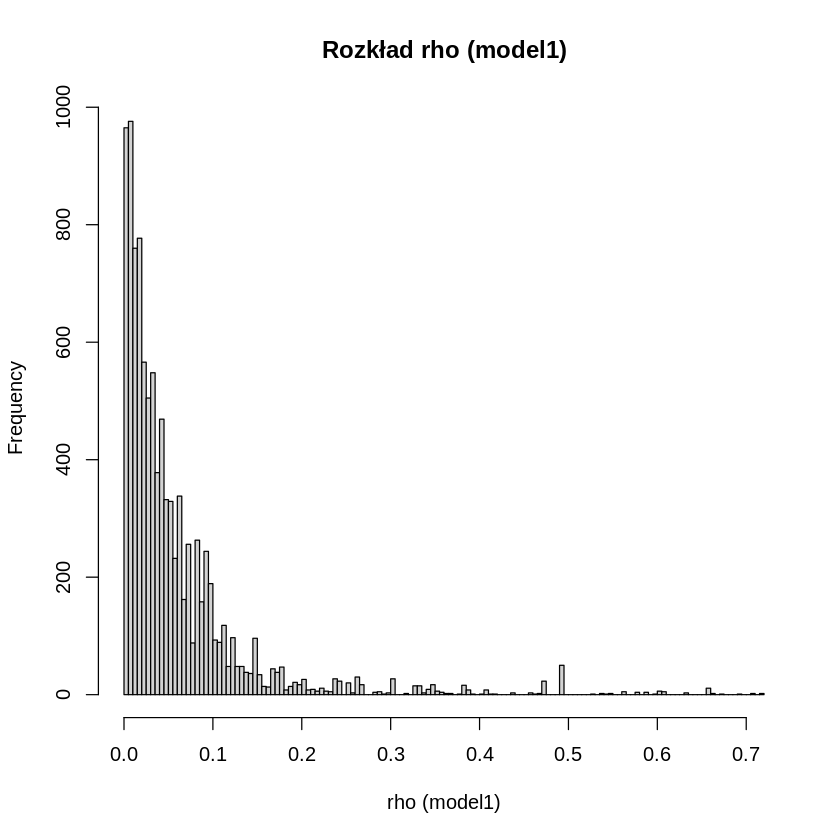

In [97]:
hist(x = fitted(model1), xlab = "rho (model1)", breaks = "fd", main = "Rozkład rho (model1)")

## Krok 5 -- próba nielosowa i dopisanie $\hat{\rho}_i$

In [98]:
proba_nielos <- dane %>% 
  filter(is.na(id_popyt)) %>%
  select(id_popyt, id_cbop, id_jednostki, sek:zawod_kod2, wolne_miejsca_cbop, jedna_zmiana) %>%
  mutate_at(vars(sek, woj, zawod_kod2), as.factor)

head(proba_nielos)

,id_popyt,id_cbop,id_jednostki,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca_cbop,jedna_zmiana
,<int>,<int>,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<int>,<lgl>
1,NA,1,03950533c4990dd3e6b80312d98d7bf7877d6cdc,1,D,P,22,2,1,TRUE
2,NA,1,fc1e0932170f7ec7da987a060bfb7ab01a928b3f,1,D,P,14,9,2,TRUE
3,NA,1,ec812df7c443d9681645795c35687241418466ea,1,D,P,12,5,3,FALSE
4,NA,1,ec812df7c443d9681645795c35687241418466ea,1,D,P,12,9,4,TRUE
5,NA,1,f59016808a975f0f45ab571899d50d4931cebaeb,1,D,P,24,2,2,TRUE
6,NA,1,76f26af4360f38e53850ea0628131fd7a8c51a82,1,D,P,4,2,1,TRUE


Aby przypisać $\hat{\rho}_i$ z danego modelu należy wykorzystać funkcję `predict` podająć argumenty:

+ `object` -- wskazujemy `model1` lub `model2`,
+ `newdata` -- wskazujemy zbiór danych,
+ `type = "response"` -- wskazujemy, że chcemy dostać prawdopodobieństwa. 

Następnie tworzymy odpowiednie wagi `w1` i `w2` na podstawie `rho1` i `rho2`.

In [99]:
proba_nielos <- proba_nielos %>%
      mutate(rho1 = predict(model1, proba_nielos, type = "response"),
             rho2 = predict(model2, proba_nielos, type = "response"),
             w1 = 1/rho1,
             w2 = 1/rho2)

head(proba_nielos)

,id_popyt,id_cbop,id_jednostki,sek,klasa_pr,sekc_pkd,woj,zawod_kod2,wolne_miejsca_cbop,jedna_zmiana,rho1,rho2,w1,w2
,<int>,<int>,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,1,03950533c4990dd3e6b80312d98d7bf7877d6cdc,1,D,P,22,2,1,TRUE,0.01638184,0.02006381,61.04321,49.840990
2,NA,1,fc1e0932170f7ec7da987a060bfb7ab01a928b3f,1,D,P,14,9,2,TRUE,0.09852425,0.10523109,10.14979,9.502895
3,NA,1,ec812df7c443d9681645795c35687241418466ea,1,D,P,12,5,3,FALSE,0.04992116,0.05915892,20.03159,16.903621
4,NA,1,ec812df7c443d9681645795c35687241418466ea,1,D,P,12,9,4,TRUE,0.06176530,0.07366137,16.19032,13.575637
5,NA,1,f59016808a975f0f45ab571899d50d4931cebaeb,1,D,P,24,2,2,TRUE,0.02531540,0.03077294,39.50164,32.496079
6,NA,1,76f26af4360f38e53850ea0628131fd7a8c51a82,1,D,P,4,2,1,TRUE,0.02616224,0.03027070,38.22303,33.035240


## Krok 6 -- estymacja (bez wariancji)

Naszym celem jest oszacowanie odsetka badanej cechy (y = 1 gdy na jedną zmianę, 0 w przeciwnym wypadku.

$$
\hat{\theta}_{PS} = \frac{\sum_{i \in CBOP} y_i w_{i}}{\sum_{i \in CBOP} w_{i}}
$$

Jednak w naszym zbiorze mamy też zmienna informującą o liczbie wolnych miejsc pracy (to jest tylko zmienna określająca częstość żeby nie mieć zbyt dużego zbioru danych). Dlatego zastosujemy następujący estymator

$$
\hat{\theta}_{PS} = \frac{\sum_{i \in CBOP} y_i w_{i}f_i}{\sum_{i \in CBOP} w_{i}f_i},
$$

gdzie $f_i$ to zmienna określająca częstość.

W R możemy w tym celu zastosować funkcję `weighted.mean`.


In [100]:
proba_nielos %>%
  summarise(jedna_zmiana_naive = weighted.mean(jedna_zmiana, wolne_miejsca_cbop), 
            jedna_zmiana_model1 = weighted.mean(jedna_zmiana, w1*wolne_miejsca_cbop),
            jedna_zmiana_model2 = weighted.mean(jedna_zmiana, w2*wolne_miejsca_cbop))

jedna_zmiana_naive,jedna_zmiana_model1,jedna_zmiana_model2
<dbl>,<dbl>,<dbl>
0.5204615,0.7562009,0.7887356


Dla porównania z poprzednich zajęć:

+ Po uwzględnieniu kalibracji ten odsetek wynosił 53% (sek, zawod)
+ Po uwzględnieniu kalibracji ten odsetek wynosił 62% (sek, zawod, + wielkość)